In [ ]:
!pip install geopandas

     |████████████████████████████████| 1.0 MB 5.1 MB/s 
     |████████████████████████████████| 6.3 MB 48.3 MB/s 
     |████████████████████████████████| 15.4 MB 35 kB/s 


In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd

import folium
from folium import plugins

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from sklearn.linear_model import Lasso

import warnings

warnings.filterwarnings(action = 'ignore')
plt.rc("font",family="Malgun Gothic")
plt.rc("axes",unicode_minus=False)
pd.set_option('display.max_columns', None)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df2 = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/2.광양시_재활용품분리수거_장려금지급내역(수정수정삭제).csv')
df3 = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/3.광양시_금호동_집적장별_재할용품통계(수정).csv')
df4 = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/4.광양시_건축물_표제부(수정수정수정수정).csv', encoding = 'euc-kr')

df15 = gpd.read_file('/content/gdrive/MyDrive/Colab Notebooks/15.광양시_건물정보(외부데이터).geojson')
df11 = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/11.광양시_동별인구수_세대수.csv')

# 목차

## 1. 전처리

    1.1 df2 ('2.광양시_재활용품분리수거_장려금지급내역.csv')
        1.1.1 kg단위로 환산
        1.1.2 Column 주요배출항목 / 기타배출항목으로 단일화

    1.2 df3 ('3.광양시_금호동_집적장별_재할용품통계.csv')
        - kg단위로 통일

    1.3 df4 ('4.광양시_건축물_표제부.csv')
        - Columns 정리 
        - 건물명별로 household_cnt 집계
        
    1.4 df11 ('11.광양시_동별인구수_세대수.csv')
        - Columns 정리
        
    1.5 외부데이터 df15 ('15.광양시_건물정보.geojson')
    
## 2. 데이터 종합


## 3. Feature Engineering
    3.1 추정거주인구 보간
    3.2 최종데이터 종합
    3.3 주요배출항목(A_recycle) 보간
    3.4 기타배출항목(B_recycle) 보간
    3.5 총 장려금교부액(subsidy) 보간

## 4. 클러스터링
    4.1 필요 Module
    4.2 시각화
    4.3 최적 k값 찾기

## 5. 수거기 최적 위치 선정
    5.1 각 Feature별 가중치 값 찾기
    5.2 구간별 점수화
    5.3 결과
    
## 6. 금호동
    6.1 주요배출항목(A_recycle) 보간
    6.2 기타배출항목(B_recycle) 보간
    6.3 총 장려금교부액(subsidy) 보간
    6.4 각 Feature 가중치 값 산정 및 구간화
    6.5 결과

## 1. 전처리

### 1.1 df2 ('2.광양시_재활용품분리수거_장려금지급내역.csv')

#### 1.1.1 kg단위로 환산 
    - 유리병(kg당 70원), 페트병(kg당 40원), 플라스틱류(kg당 30원), 폐형광등(kg당 150원), 필름류포장재비닐(kg당 200원), 폐건전지류(kg당 600원), 종이팩(kg당 200원), 소형가전(kg당 300원), 휴대폰(kg당 1000원)
#### 1.1.2 Column 주요배출항목 / 기타배출항목으로 단일화
    - 주요배출항목('A_recycle') : glass, pet, plastic
    - 기타배출항목('B_recycle') : vinyl, battery, carton, smallappliance, hp

In [ ]:
df2_sum = pd.DataFrame(df2.groupby(['emd_nm', 'complex_nm'])['glass', 'pet', 'plastic', 'lamp', 'vinyl', 'battery', 'carton', 'smallappliance', 'hp', 'subsidy'].mean()).reset_index()

df2_sum['glass/kg'] = (df2_sum['glass'] / 70)
df2_sum['pet/kg'] = (df2_sum['pet'] / 40)
df2_sum['plastic/kg'] = (df2_sum['plastic'] / 30)
df2_sum['lamp/kg'] = (df2_sum['lamp'] / 150)
df2_sum['vinyl/kg'] = (df2_sum['vinyl'] / 200)
df2_sum['battery/kg'] = (df2_sum['battery'] / 600)
df2_sum['carton/kg'] = (df2_sum['carton'] / 200)
df2_sum['smallappliance/kg'] = (df2_sum['smallappliance'] / 300)
df2_sum['hp/kg'] = (df2_sum['hp'] / 1000)

df2_sum = df2_sum[['emd_nm', 'complex_nm', 'glass', 'glass/kg', 'pet', 'pet/kg', 'plastic', 'plastic/kg', 'lamp', 'lamp/kg',
                   'vinyl', 'vinyl/kg', 'battery', 'battery/kg', 'carton', 'carton/kg', 'smallappliance', 'smallappliance/kg', 
                   'hp', 'hp/kg', 'subsidy']]
df2_sum = df2_sum.rename(columns = {'complex_nm' : 'bldg_nm'})

In [ ]:
df2_sum['A_recycle'] = df2_sum['glass/kg'] + df2_sum['pet/kg'] + df2_sum['plastic/kg']
df2_sum['B_recycle'] = df2_sum['vinyl/kg'] + df2_sum['battery/kg'] + df2_sum['carton/kg'] + df2_sum['smallappliance/kg'] + df2_sum['hp/kg'] + df2_sum['lamp/kg']
df2_sum = df2_sum[['emd_nm', 'bldg_nm', 'A_recycle', 'B_recycle', 'subsidy']]

### 1.2 df3 ('3.광양시_금호동_집적장별_재할용품통계.csv')
    - paper는 최초 ton단위로 집계되었으므로 kg단위로 통일

In [ ]:
df3['paper'] = (df3['paper'] * 1000)

### 1.3 df4 ('4.광양시_건축물_표제부.csv')
    - Columns 정리 
    - 건물명별로 household_cnt 집계

In [ ]:
df4 = df4[['bldg_nm', 'land_location', 'bun', 'ji', 'main_annex_gbn', 'purpose_nm', 'etc_purpose_nm', 'household_cnt', 'lon', 'lat']]

df4.dropna(inplace = True)

df4_sum = pd.DataFrame(df4.groupby('bldg_nm')['household_cnt'].sum()).reset_index()

new_df4 = df4.drop_duplicates(['bldg_nm']).reset_index()
new_df4.drop(['index'], axis = 1, inplace = True)

final = new_df4.merge(df4_sum, on = 'bldg_nm', how = 'left')
final.drop(['household_cnt_x'], axis = 1, inplace = True)
final = final.rename(columns = {'household_cnt_y' : 'household_cnt'})

### 1.4. df11 ('11.광양시_동별인구수_세대수.csv')
    - Columns 정리

In [ ]:
df11 = df11[['emd_nm', 'hh_pop_cnt_2020']]

### 1.5 외부데이터 df15 ('15.광양시_건물정보.geojson')
    - "(광양시) 전기자동차 충전소 최적입지 선정" 과제에서 데이터 가져옴.
    - 법정동을 행정동으로 변경
    - df11을 활용해 동별인구추산

In [ ]:
df15['법정동명'] = df15['법정동명'].str[0:12]
df15 = df15[(df15.세부용도명 == '다가구주택') | (df15.세부용도명 == '단독주택') | (df15.세부용도명 == '아파트')| (df15.세부용도명 == '연립주택')| (df15.세부용도명 == '다세대주택')| (df15.세부용도명 == '공관')| (df15.세부용도명 == '기숙사')]
df15 = df15[['법정동코드', '법정동명', '지번', '건물명', '건물동명', '건물연면적', '주요용도명', '세부용도명', 'geometry']]
df15 = df15[df15['주요용도명'] != '제2종근린생활시설']
df15.reset_index(inplace = True)
df15.drop(['index'], axis = 1, inplace = True)

# 법정동을 행정동으로 변경

golyak_list = ['전라남도 광양시 도이동', '전라남도 광양시 성황동', '전라남도 광양시 중군동', '전라남도 광양시 황금동', '전라남도 광양시 황길동']
jungma_list = ['전라남도 광양시 중동','전라남도 광양시 마동']

for i in range(len(df15)):
    if df15['법정동명'][i] in golyak_list :
        df15['법정동명'][i] = '전라남도 광양시 골약동'
        
for i in range(len(df15)):
    if df15['법정동명'][i] in jungma_list :
        df15['법정동명'][i] = '전라남도 광양시 중마동'
        
# 읍/면별로 필터
광양읍 = df15[(df15.법정동명 == '전라남도 광양시 광양읍')]
봉강면 = df15[(df15.법정동명 == '전라남도 광양시 봉강면')]
옥룡면 = df15[(df15.법정동명 == '전라남도 광양시 옥룡면')]
옥곡면 = df15[(df15.법정동명 == '전라남도 광양시 옥곡면')]
진상면 = df15[(df15.법정동명 == '전라남도 광양시 진상면')]
진월면 = df15[(df15.법정동명 == '전라남도 광양시 진월면')]
다압면 = df15[(df15.법정동명 == '전라남도 광양시 다압면')]
중마동 = df15[(df15.법정동명 == '전라남도 광양시 중마동')]
골약동 = df15[(df15.법정동명 == '전라남도 광양시 골약동')]
광영동 = df15[(df15.법정동명 == '전라남도 광양시 광영동')]
금호동 = df15[(df15.법정동명 == '전라남도 광양시 금호동')]
태인동 = df15[(df15.법정동명 == '전라남도 광양시 태인동')]


# 읍/면별로 주택연면적 산출
광양읍주택연면적 = 광양읍['건물연면적'].sum()
봉강면주택연면적 = 봉강면['건물연면적'].sum()
옥룡면주택연면적 = 옥룡면['건물연면적'].sum()
옥곡면주택연면적 = 옥곡면['건물연면적'].sum()
진상면주택연면적 = 진상면['건물연면적'].sum()
진월면주택연면적 = 진월면['건물연면적'].sum()
다압면주택연면적 = 다압면['건물연면적'].sum()
골약동주택연면적 = 골약동['건물연면적'].sum()
중마동주택연면적 = 중마동['건물연면적'].sum()
광영동주택연면적 = 광영동['건물연면적'].sum()
금호동주택연면적 = 금호동['건물연면적'].sum()
태인동주택연면적 = 태인동['건물연면적'].sum()

# 인구
광양읍인구 = df11.iloc[0, 1]
봉강면인구 = df11.iloc[1, 1]
옥룡면인구 = df11.iloc[2, 1]
옥곡면인구 = df11.iloc[3, 1]
진상면인구 = df11.iloc[4, 1]
진월면인구 = df11.iloc[5, 1]
다압면인구 = df11.iloc[6, 1]
골약동인구 = df11.iloc[7, 1]
중마동인구 = df11.iloc[8, 1]
광영동인구 = df11.iloc[9, 1]
금호동인구 = df11.iloc[10, 1]
태인동인구 = df11.iloc[11, 1]


# 행정동별 1인당 주거면적
광양읍인당주거면적 = 광양읍주택연면적 / 광양읍인구
봉강면인당주거면적 = 봉강면주택연면적 / 봉강면인구
옥룡면인당주거면적 = 옥룡면주택연면적 / 옥룡면인구
옥곡면인당주거면적 = 옥곡면주택연면적 / 옥곡면인구
진상면인당주거면적 = 진상면주택연면적 / 진상면인구
진월면인당주거면적 = 진월면주택연면적 / 진월면인구
다압면인당주거면적 = 다압면주택연면적 / 다압면인구
골약동인당주거면적 = 골약동주택연면적 / 골약동인구
중마동인당주거면적 = 중마동주택연면적 / 중마동인구
광영동인당주거면적 = 광영동주택연면적 / 광영동인구
금호동인당주거면적 = 금호동주택연면적 / 금호동인구
태인동인당주거면적 = 태인동주택연면적 / 태인동인구

# 광양읍 주거용도건물 인구추산
광양읍['추정거주인구'] = 광양읍['건물연면적']/광양읍인당주거면적
봉강면['추정거주인구'] = 봉강면['건물연면적']/봉강면인당주거면적
옥룡면['추정거주인구'] = 옥룡면['건물연면적']/옥룡면인당주거면적
옥곡면['추정거주인구'] = 옥곡면['건물연면적']/옥곡면인당주거면적
진상면['추정거주인구'] = 진상면['건물연면적']/진상면인당주거면적
진월면['추정거주인구'] = 진월면['건물연면적']/진월면인당주거면적
다압면['추정거주인구'] = 다압면['건물연면적']/다압면인당주거면적
골약동['추정거주인구'] = 골약동['건물연면적']/골약동인당주거면적
중마동['추정거주인구'] = 중마동['건물연면적']/중마동인당주거면적
광영동['추정거주인구'] = 광영동['건물연면적']/광영동인당주거면적
금호동['추정거주인구'] = 금호동['건물연면적']/금호동인당주거면적
태인동['추정거주인구'] = 태인동['건물연면적']/태인동인당주거면적



merge_df15 = pd.concat([광양읍, 봉강면, 옥룡면, 옥곡면, 진상면, 진월면, 다압면, 골약동, 중마동, 
                       광영동, 금호동, 태인동])
merge_df15 = merge_df15.reset_index()
merge_df15.drop('index', axis = 1, inplace = True)

df_15 = merge_df15[(merge_df15.주요용도명 == '공동주택')]
df_15 = pd.DataFrame(df_15.groupby('건물명')['추정거주인구'].sum()).reset_index()

new = merge_df15.merge(df_15, on = '건물명', how = 'right')
new = new.drop_duplicates(['건물명'])
new = new.rename(columns = {'추정거주인구_y' : '추정거주인구'})


## 2. 데이터 종합

In [ ]:
# '장미아파트' -> '장미연립아파트'로 명칭 변경
final.loc[final.bldg_nm == '장미아파트', ('bldg_nm')] = '장미연립아파트'
tmp = final[(final.bldg_nm != '장미연립아파트') & (final.bldg_nm != '장미아파트')]
target = final[final.bldg_nm == '장미연립아파트'][['bldg_nm', 'land_location', 'bun','ji','main_annex_gbn','purpose_nm','etc_purpose_nm', 'lon', 'lat']]
target['household_cnt'] = 661+172
tartget = target[0:1]
final = pd.concat([tmp, target[0:1]])
final.reset_index(inplace = True)
final.loc[final.bldg_nm == '장미연립아파트']

new = new.rename(columns = {'건물명' : 'bldg_nm'})

# 최종 4번 데이터 + 최종 15번 데이터
final1 = final.merge(new, on = 'bldg_nm', how = 'left')

## 3. Feature Engineering

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso, Ridge, SGDRegressor, ElasticNet, BayesianRidge
from sklearn.linear_model import LogisticRegression

### 3.1 추정거주인구 보간

In [ ]:
final1 = final1[['bldg_nm', 'land_location', 'bun', 'ji', 'main_annex_gbn', 'purpose_nm', 'etc_purpose_nm', 'lon', 'lat', 'household_cnt', 
                'geometry', '법정동명']]
final1['land_location'] = final1['land_location'].str[0:12]

golyak_list = ['전라남도 광양시 도이동', '전라남도 광양시 성황동', '전라남도 광양시 중군동', '전라남도 광양시 황금동', '전라남도 광양시 황길동']
jungma_list = ['전라남도 광양시 중동 ','전라남도 광양시 마동 ']

for i in range(len(final1)):
    if final1['land_location'][i] in golyak_list :
        final1['land_location'][i] = '전라남도 광양시 골약동'
        
for i in range(len(final1)):
    if final1['land_location'][i] in jungma_list :
        final1['land_location'][i] = '전라남도 광양시 중마동'

        
final1['추정거주인구'] = None

광양읍세대당인구 = df11.iloc[0, 1]
옥곡면세대당인구 = df11.iloc[3, 1]
다압면세대당인구 = df11.iloc[6, 1]
중마동세대당인구 = df11.iloc[8, 1]
광영동세대당인구 = df11.iloc[9, 1]
금호동세대당인구 = df11.iloc[10, 1]
태인동세대당인구 = df11.iloc[11, 1]


for i in range(len(final1)):
    if final1.land_location[i] == '전라남도 광양시 광양읍':
        final1.추정거주인구[i] = (final1.household_cnt[i] * 광양읍세대당인구)
    elif final1.land_location[i] == '전라남도 광양시 옥곡면':
        final1.추정거주인구[i] = (final.household_cnt[i] * 옥곡면세대당인구)
    elif final1.land_location[i] == '전라남도 광양시 다압면':
        final1.추정거주인구[i] = (final.household_cnt[i] * 다압면세대당인구)
    elif final1.land_location[i] == '전라남도 광양시 중마동':
        final1.추정거주인구[i] = (final.household_cnt[i] * 중마동세대당인구)
    elif final1.land_location[i] == '전라남도 광양시 광영동':
        final1.추정거주인구[i] = (final.household_cnt[i] * 광영동세대당인구)
    elif final1.land_location[i] == '전라남도 광양시 금호동':
        final1.추정거주인구[i] = (final.household_cnt[i] * 금호동세대당인구)
    elif final1.land_location[i] == '전라남도 광양시 태인동':
        final1.추정거주인구[i] = (final.household_cnt[i] * 태인동세대당인구)

        

### 3.2 데이터 종합

In [ ]:
final1 = final1.merge(df2_sum, on = 'bldg_nm', how = 'left')

final1 = final1.drop(['emd_nm', '법정동명'], axis = 1)

final1 = final1.astype({'추정거주인구' : 'float64'})
final1 = final1.reset_index()
final1 = final1.drop('index', axis = 1)

### 3.3 주요배출항목(A_recycle) 보간

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression

In [ ]:
# 금호동 데이터셋 
final1_geumho = final1[(final1.land_location == '전라남도 광양시 금호동')]
# 금호동 제외
final1 = final1[(final1.land_location != '전라남도 광양시 금호동')]

# train / test 분리 전 데이터 만들기
ml_final = final1[['household_cnt', '추정거주인구', 'A_recycle', 'B_recycle', 'subsidy']]

scaler = MinMaxScaler()
scaler.fit(ml_final)
ml_final = scaler.transform(ml_final)
ml_final = pd.DataFrame(ml_final, columns = ('household_cnt', '추정거주인구', 'A_recycle', 'B_recycle', 'subsidy'))
ml_final['land_location'] = final1['land_location']
ml_final1 = pd.get_dummies(ml_final)
ml_final1



# train / test set 분리
train = ml_final1.loc[ml_final1['A_recycle'].notnull()]
test = ml_final1.loc[ml_final1['A_recycle'].isna()]

X_train = train[['household_cnt', '추정거주인구', 'land_location_전라남도 광양시 광양읍', 'land_location_전라남도 광양시 광영동', 'land_location_전라남도 광양시 다압면', 'land_location_전라남도 광양시 옥곡면', 
               'land_location_전라남도 광양시 중마동', 'land_location_전라남도 광양시 태인동']]
X_test = test[['household_cnt', '추정거주인구', 'land_location_전라남도 광양시 광양읍', 'land_location_전라남도 광양시 광영동', 'land_location_전라남도 광양시 다압면', 'land_location_전라남도 광양시 옥곡면', 
               'land_location_전라남도 광양시 중마동', 'land_location_전라남도 광양시 태인동']]
y_train = train['A_recycle']
y_test = test['A_recycle']

model_ridge = Ridge(solver = 'svd', alpha = 1).fit(X_train, y_train)

ridge_pred_A_recycle = model_ridge.predict(X_test)
#ridge_pred_A_recycle

In [ ]:
# Module

## Tree
from sklearn.tree import ExtraTreeRegressor
## RF 
model_rf = RandomForestRegressor().fit(X_train, y_train)
score = model_rf.score(X_train, y_train)
print("RF Score: {:.2f}%".format(score * 100))

## ETR
model_etr = ExtraTreeRegressor().fit(X_train, y_train)
score = model_etr.score(X_train, y_train)
print("ETR Score: {:.2f}%".format(score * 100))



## Linear
from sklearn.linear_model import SGDRegressor
## Ridge
model_ridge = Ridge().fit(X_train, y_train)
score = model_ridge.score(X_train, y_train)
print("Ridge Score: {:.2f}%".format(score * 100))

## Ridge(Tuning)
model_ridge = Ridge(solver = 'sparse_cg', alpha = 0.001).fit(X_train, y_train)
score = model_ridge.score(X_train, y_train)
print("Ridge(Tuning) Score: {:.2f}%".format(score * 100))

## SGD
model_SGD = SGDRegressor().fit(X_train, y_train)
score = model_SGD.score(X_train, y_train)
print("SGD Score: {:.2f}%".format(score * 100))

## Linear Regression >> Adoption
model_lr = LinearRegression().fit(X_train, y_train)
score = model_lr.score(X_train, y_train)
print("LR Score: {:.2f}%".format(score * 100))

RF Score: 85.91%
ETR Score: 100.00%
Ridge Score: 5.02%
Ridge(Tuning) Score: 6.16%
SGD Score: 1.38%
LR Score: 6.19%


In [ ]:
## Linear Regression
# LR Score
model_lr = LinearRegression(fit_intercept = False).fit(X_train, y_train)
score = model_lr.score(X_train, y_train)
print("LR Score: {:.2f}%".format(score * 100))

# LR Predict
lr_pred_A_recycle = model_lr.predict(X_test)
lr_pred_A_recycle

## Res
# LR 모델은 파라미터 조정할만한게 딱히 없다 
# "fit_intercept" 파라미터 조정 결과  6.19% >>> 5.97% 로 성능하락
# Ridge모델로 다시 돌아가야할듯

LR Score: 5.97%


array([0.11560189, 0.11560189, 0.13449452, 0.11551014, 0.11532664,
       0.11505139, 0.13404906, 0.11486789, 0.11486789, 0.11486789,
       0.08210908, 0.11477614, 0.11587714, 0.11450089, 0.11541839,
       0.11514314, 0.11431739, 0.11413389, 0.11413389, 0.11413389,
       0.11486789, 0.11486789, 0.11413389, 0.11413389, 0.11413389,
       0.11413389, 0.11486789, 0.11413389, 0.11413389, 0.11413389,
       0.08114268, 0.11459264, 0.08123932, 0.13334906, 0.13334906,
       0.13334906, 0.08104604, 0.11468439, 0.11450089, 0.11395039,
       0.08114268, 0.0814326 , 0.08123932, 0.08317211, 0.0048194 ,
       0.1334127 , 0.13322179, 0.08713433, 0.00135669, 0.11514314,
       0.11514314, 0.11523604, 0.08221924, 0.11486789, 0.11486789,
       0.11486789, 0.11477614, 0.11468439, 0.11409989, 0.13403028,
       0.08267799, 0.11486789, 0.11413389, 0.11413389, 0.11413389,
       0.11413389, 0.11413389, 0.11413389, 0.11413389, 0.11413389,
       0.11413389, 0.11413389, 0.11413389, 0.11413389, 0.11413

In [ ]:
# Module
#from sklearn.model_selection import GridSearchCV

# param_grid 조정
#params = {
#    'alpha': [0.001, 0.01, 0.1, 1.0, 10, 100],
#    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg']
#}

#ridge = Ridge()


#grid_ridge = GridSearchCV(ridge, param_grid=params)
#grid_ridge.fit(X_train, y_train)

#print('best parameters : ', grid_ridge.best_params_)
#print('best score : ', grid_ridge.best_score_)





## Ridge

# Ridge Score
model_ridge = Ridge(alpha = 0.001, solver = 'sparse_cg').fit(X_train, y_train)
score = model_ridge.score(X_train, y_train)
print("Ridge Score: {:.2f}%".format(score * 100))


## Res
# GridSearchCV 결과가 이상함
# 최종 Ridge 모델 파라미터값 : {alpha = 0.001, solver = 'sparse_cg'}

Ridge Score: 6.16%


In [ ]:
# 파라미터값 적용한 'A_recycle' 값

model_ridge = Ridge(alpha = 0.001, solver = 'sparse_cg').fit(X_train, y_train)

ridge_pred_A_recycle = model_ridge.predict(X_test)
ridge_pred_A_recycle

array([0.11804719, 0.11804719, 0.13793341, 0.11796323, 0.11779531,
       0.11754344, 0.1374937 , 0.11737552, 0.11737552, 0.11737552,
       0.08281711, 0.11729156, 0.11829907, 0.11703968, 0.11787927,
       0.1176274 , 0.11687176, 0.11670384, 0.11670384, 0.11670384,
       0.11737552, 0.11737552, 0.11670384, 0.11670384, 0.11670384,
       0.11670384, 0.11737552, 0.11670384, 0.11670384, 0.11670384,
       0.08194074, 0.11712364, 0.08202838, 0.13680272, 0.13680272,
       0.13680272, 0.08185311, 0.1172076 , 0.11703968, 0.11653593,
       0.08194074, 0.08220365, 0.08202838, 0.08378111, 0.05534566,
       0.13686553, 0.13667709, 0.08737419, 0.0525321 , 0.1176274 ,
       0.1176274 , 0.11769726, 0.08292987, 0.11737552, 0.11737552,
       0.11737552, 0.11729156, 0.1172076 , 0.11672315, 0.13738982,
       0.08334966, 0.11737552, 0.11670384, 0.11670384, 0.11670384,
       0.11670384, 0.11670384, 0.11670384, 0.11670384, 0.11670384,
       0.11670384, 0.11670384, 0.11670384, 0.11670384, 0.11670

In [ ]:
# Ridge Weight
print("Ridge Weight: {}".format(model_ridge.coef_))
# Ridge Bias
print("Ridge Bias: {}".format(model_ridge.intercept_))

Ridge Weight: [ 1.20194223 -0.94644266  0.06509529  0.03056568  0.          0.08538572
  0.08548894  0.12657479]
Ridge Bias: 0.0512874238494094


### Try to DL

In [ ]:
# 금호동 데이터셋 
final1_geumho = final1[(final1.land_location == '전라남도 광양시 금호동')]
# 금호동 제외
final1 = final1[(final1.land_location != '전라남도 광양시 금호동')]

# train / test 분리 전 데이터 만들기
ml_final = final1[['household_cnt', '추정거주인구', 'A_recycle', 'B_recycle', 'subsidy']]

scaler = MinMaxScaler()
scaler.fit(ml_final)
ml_final = scaler.transform(ml_final)
ml_final = pd.DataFrame(ml_final, columns = ('household_cnt', '추정거주인구', 'A_recycle', 'B_recycle', 'subsidy'))
ml_final['land_location'] = final1['land_location']
ml_final1 = pd.get_dummies(ml_final)
ml_final1



# train / test set 분리
train = ml_final1.loc[ml_final1['A_recycle'].notnull()]
test = ml_final1.loc[ml_final1['A_recycle'].isna()]

In [ ]:
x_train_full = ml_final[['land_location', 'household_cnt', '추정거주인구']]
x_train_full = pd.get_dummies(x_train_full)
y_train_full = ml_final['A_recycle']

x_test = ml_final[['land_location', 'household_cnt', '추정거주인구']]
x_test = pd.get_dummies(x_test)
y_test = ml_final['A_recycle']

In [ ]:
# 전처리
mean = np.mean(x_train_full, axis = 0)
std = np.std(x_train_full, axis = 0)

x_train_preprocessed = (x_train_full - mean) / std
x_test = (x_test - mean) / std

x_train, x_val, y_train, y_val = train_test_split(x_train_preprocessed, y_train_full,
                                                 test_size = .3,
                                                 random_state = 111)

In [ ]:
x_train

,household_cnt,추정거주인구,land_location_전라남도 광양시 광양읍,land_location_전라남도 광양시 광영동,land_location_전라남도 광양시 다압면,land_location_전라남도 광양시 옥곡면,land_location_전라남도 광양시 중마동,land_location_전라남도 광양시 태인동
126,1.359138,1.424169,-1.055290,-0.375639,-0.073521,-0.128037,1.626978,-0.104257
81,-0.507321,-0.494656,-1.055290,-0.375639,-0.073521,-0.128037,1.626978,-0.104257
150,-0.195463,-0.172771,-1.055290,2.662134,-0.073521,-0.128037,-0.614636,-0.104257
124,1.070728,0.953109,-1.055290,-0.375639,-0.073521,-0.128037,1.626978,-0.104257
47,-0.366633,-0.365826,-1.055290,2.662134,-0.073521,-0.128037,-0.614636,-0.104257
...,...,...,...,...,...,...,...,...
169,-0.195463,-0.208758,0.947607,-0.375639,-0.073521,-0.128037,-0.614636,-0.104257
19,-0.504976,-0.492466,0.947607,-0.375639,-0.073521,-0.128037,-0.614636,-0.104257
86,-0.514355,-0.501377,-1.055290,-0.375639,-0.073521,-0.128037,1.626978,-0.104257
108,0.414184,0.453480,-1.055290,-0.375639,-0.073521,7.810250,-0.614636,-0.104257


In [ ]:
print('학습 데이터: {}\t레이블: {}'.format(x_train_full.shape, y_train_full.shape))
print('학습 데이터: {}\t레이블: {}'.format(x_train.shape, y_train.shape))
print('검증 데이터: {}\t레이블: {}'.format(x_val.shape, y_val.shape))
print('테스트 데이터: {}\t레이블: {}'.format(x_test.shape, y_test.shape))

학습 데이터: (186, 8)	레이블: (186,)
학습 데이터: (130, 8)	레이블: (130,)
검증 데이터: (56, 8)	레이블: (56,)
테스트 데이터: (186, 8)	레이블: (186,)


In [ ]:
# Module Import
import tensorflow as tf
from tensorflow.keras.datasets.boston_housing import load_data
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import plot_model

In [ ]:
# 모델 구성

model = Sequential([Dense(12, activation = 'relu', input_dim = 8, name = 'dense1'),
                    Dense(8, activation = 'relu', name = 'dense2'),
                    Dense(1, activation = 'softmax', name = 'output')])
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               (None, 12)                108       
_________________________________________________________________
dense2 (Dense)               (None, 8)                 104       
_________________________________________________________________
output (Dense)               (None, 1)                 9         
Total params: 221
Trainable params: 221
Non-trainable params: 0
_________________________________________________________________


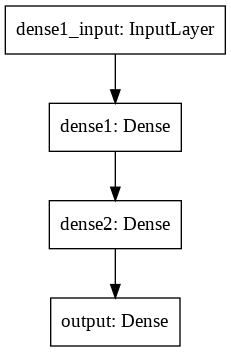

In [ ]:
plot_model(model)

In [ ]:
model.compile(loss = 'mse',
              optimizer = 'adam',
              metrics = ['acc'])

In [ ]:
model.fit(x_train, y_train, epochs = 100, batch_size = 1, validation_data = (x_val, y_val))

Epoch 1/100
130/130 [==============================] - 1s 3ms/step - loss: nan - acc: 0.0154 - val_loss: nan - val_acc: 0.0000e+00
Epoch 2/100
130/130 [==============================] - 0s 2ms/step - loss: nan - acc: 0.0154 - val_loss: nan - val_acc: 0.0000e+00
Epoch 3/100
130/130 [==============================] - 0s 2ms/step - loss: nan - acc: 0.0154 - val_loss: nan - val_acc: 0.0000e+00
Epoch 4/100
130/130 [==============================] - 0s 2ms/step - loss: nan - acc: 0.0154 - val_loss: nan - val_acc: 0.0000e+00
Epoch 5/100
130/130 [==============================] - 0s 2ms/step - loss: nan - acc: 0.0154 - val_loss: nan - val_acc: 0.0000e+00
Epoch 6/100
130/130 [==============================] - 0s 2ms/step - loss: nan - acc: 0.0154 - val_loss: nan - val_acc: 0.0000e+00
Epoch 7/100
130/130 [==============================] - 0s 2ms/step - loss: nan - acc: 0.0154 - val_loss: nan - val_acc: 0.0000e+00
Epoch 8/100
130/130 [==============================] - 0s 2ms/step - loss: nan - ac

KeyboardInterrupt: ignored

In [ ]:
print(x_train_full.shape)
print(y_train_full.shape)
print(x_test.shape)
print(y_test.shape)

In [ ]:
_, accuracy = model.evaluate(x_test, y_test)

In [ ]:
pred = model.predict(x_test)
pred

### 3.4 기타배출항목(B_recycle) 보간

In [ ]:
train = ml_final1.loc[ml_final1['B_recycle'].notnull()]
test = ml_final1.loc[ml_final1['B_recycle'].isna()]

X_train = train[['household_cnt', '추정거주인구', 'land_location_전라남도 광양시 광양읍', 'land_location_전라남도 광양시 광영동', 'land_location_전라남도 광양시 다압면', 'land_location_전라남도 광양시 옥곡면', 
               'land_location_전라남도 광양시 중마동', 'land_location_전라남도 광양시 태인동']]
X_test = test[['household_cnt', '추정거주인구', 'land_location_전라남도 광양시 광양읍', 'land_location_전라남도 광양시 광영동', 'land_location_전라남도 광양시 다압면', 'land_location_전라남도 광양시 옥곡면', 
               'land_location_전라남도 광양시 중마동', 'land_location_전라남도 광양시 태인동']]
y_train = train['B_recycle']
y_test = test['B_recycle']

model_ridge = Ridge().fit(X_train, y_train)

ridge_pred_B_recycle = model_ridge.predict(X_test)
#ridge_pred_B_recycle

In [ ]:
# 모델별 성능 확인

# Tree
## RF 
model_rf = RandomForestRegressor().fit(X_train, y_train)
score = model_rf.score(X_train, y_train)
print("RF Score: {:.2f}%".format(score * 100))

## ETR
model_etr = ExtraTreeRegressor().fit(X_train, y_train)
score = model_etr.score(X_train, y_train)
print("ETR Score: {:.2f}%".format(score * 100))



# Linear
## Ridge
model_ridge = Ridge().fit(X_train, y_train)
score = model_ridge.score(X_train, y_train)
print("Ridge Score: {:.2f}%".format(score * 100))

## Ridge(Tuning)  >> Adoption
model_ridge = Ridge(solver = 'sparse_cg', alpha = 0.001).fit(X_train, y_train)
score = model_ridge.score(X_train, y_train)
print("Ridge(Tuning) Score: {:.2f}%".format(score * 100))

## SGD
model_SGD = SGDRegressor().fit(X_train, y_train)
score = model_SGD.score(X_train, y_train)
print("SGD Score: {:.2f}%".format(score * 100))

## Linear Regression  >> Adoption
model_lr = LinearRegression().fit(X_train, y_train)
score = model_lr.score(X_train, y_train)
print("LR Score: {:.2f}%".format(score * 100))

RF Score: 82.92%
ETR Score: 100.00%
Ridge Score: 9.50%
Ridge(Tuning) Score: 12.44%
SGD Score: 1.39%
LR Score: 12.56%


In [ ]:
# Parameter Tuning

## Ridge Param : {solver = 'sparse_cg', alpha = 0.001}
model_ridge = Ridge(solver = 'sparse_cg', alpha = 0.0001).fit(X_train, y_train)
score = model_ridge.score(X_train, y_train)
print("Ridge(Tuning) Score: {:.2f}%".format(score * 100))

model_ridge = Ridge(solver = 'cholesky', alpha = 0.001).fit(X_train, y_train)
score = model_ridge.score(X_train, y_train)
print("Ridge(Tuning) Score: {:.2f}%".format(score * 100))


## LR 
model_lr = LinearRegression(fit_intercept = False).fit(X_train, y_train)
score = model_lr.score(X_train, y_train)
print("LR Score(Tuning): {:.2f}%".format(score * 100))


## Res
# 최종 Ridge 모델 파라미터 값 : {solver = 'sparse_cg', alpha = 0.0001}

Ridge(Tuning) Score: 12.56%
Ridge(Tuning) Score: 12.44%
LR Score(Tuning): 11.54%


In [ ]:
# 파라미터값 적용한 'B_recycle' 값

model_ridge = Ridge(solver = 'sparse_cg', alpha = 0.0001).fit(X_train, y_train)

ridge_pred_B_recycle = model_ridge.predict(X_test)
ridge_pred_B_recycle

array([0.09389928, 0.09389928, 0.11762284, 0.09373041, 0.09339268,
       0.09288607, 0.11687743, 0.09254834, 0.09254834, 0.09254834,
       0.18171972, 0.09237947, 0.09440588, 0.09187287, 0.09356154,
       0.09305494, 0.09153513, 0.0911974 , 0.0911974 , 0.0911974 ,
       0.09254834, 0.09254834, 0.0911974 , 0.0911974 , 0.0911974 ,
       0.0911974 , 0.09254834, 0.0911974 , 0.0911974 , 0.0911974 ,
       0.17992255, 0.09204174, 0.18010227, 0.11570608, 0.11570608,
       0.11570608, 0.17974284, 0.0922106 , 0.09187287, 0.09085966,
       0.17992255, 0.1804617 , 0.18010227, 0.1836966 , 0.13019208,
       0.11581256, 0.1154931 , 0.19106497, 0.12299477, 0.09305494,
       0.09305494, 0.09326107, 0.18189472, 0.09254834, 0.09254834,
       0.09254834, 0.09237947, 0.0922106 , 0.09101781, 0.11704404,
       0.18273906, 0.09254834, 0.0911974 , 0.0911974 , 0.0911974 ,
       0.0911974 , 0.0911974 , 0.0911974 , 0.0911974 , 0.0911974 ,
       0.0911974 , 0.0911974 , 0.0911974 , 0.0911974 , 0.09119

### 3.5 총 장려금교부액(subsidy) 보간

In [ ]:
train = ml_final1.loc[ml_final1['subsidy'].notnull()]
test = ml_final1.loc[ml_final1['subsidy'].isna()]

X_train = train[['household_cnt', '추정거주인구', 'land_location_전라남도 광양시 광양읍', 'land_location_전라남도 광양시 광영동', 'land_location_전라남도 광양시 다압면', 'land_location_전라남도 광양시 옥곡면', 
               'land_location_전라남도 광양시 중마동', 'land_location_전라남도 광양시 태인동']]
X_test = test[['household_cnt', '추정거주인구', 'land_location_전라남도 광양시 광양읍', 'land_location_전라남도 광양시 광영동', 'land_location_전라남도 광양시 다압면', 'land_location_전라남도 광양시 옥곡면', 
               'land_location_전라남도 광양시 중마동', 'land_location_전라남도 광양시 태인동']]
y_train = train['subsidy']
y_test = test['subsidy']

model_ridge = Ridge().fit(X_train, y_train)

ridge_pred_subsidy = model_ridge.predict(X_test)
#ridge_pred_subsidy


In [ ]:
# 모델별 성능 확인 (트리계열 제외)

# Linear
## Ridge
model_ridge = Ridge().fit(X_train, y_train)
score = model_ridge.score(X_train, y_train)
print("Ridge Score: {:.2f}%".format(score * 100))

## Ridge(Tuning)
model_ridge = Ridge(solver = 'sparse_cg', alpha = 0.001).fit(X_train, y_train)
score = model_ridge.score(X_train, y_train)
print("Ridge(Tuning) Score: {:.2f}%".format(score * 100))

## SGD
model_SGD = SGDRegressor().fit(X_train, y_train)
score = model_SGD.score(X_train, y_train)
print("SGD Score: {:.2f}%".format(score * 100))

## Linear Regression
model_lr = LinearRegression().fit(X_train, y_train)
score = model_lr.score(X_train, y_train)
print("LR Score: {:.2f}%".format(score * 100))

## Linear Regression(Tuning)
model_lr = LinearRegression(fit_intercept = False).fit(X_train, y_train)
score = model_lr.score(X_train, y_train)
print("LR(Tuning) Score: {:.2f}%".format(score * 100))

Ridge Score: 6.66%
Ridge(Tuning) Score: 8.00%
SGD Score: 2.09%
LR Score: 8.04%
LR(Tuning) Score: 7.80%


In [ ]:
# Parameter Tuning

## Ridge
model_ridge = Ridge(solver = 'sparse_cg', alpha = 0.0001).fit(X_train, y_train)
score = model_ridge.score(X_train, y_train)
print("Ridge(Tuning) Score: {:.2f}%".format(score * 100))

model_ridge = Ridge(solver = 'sag', alpha = 0.0001).fit(X_train, y_train)
score = model_ridge.score(X_train, y_train)
print("Ridge(Tuning) Score: {:.2f}%".format(score * 100))


## LR 
model_lr = LinearRegression().fit(X_train, y_train)
score = model_lr.score(X_train, y_train)
print("LR Score(Tuning): {:.2f}%".format(score * 100))


## Res
# 최종 Ridge 모델 파라미터 값 : {solver = 'sparse_cg', alpha = 0.0001}

Ridge(Tuning) Score: 8.04%
Ridge(Tuning) Score: 7.90%
LR Score(Tuning): 8.04%


In [ ]:
# 파라미터값 적용한 'subsidy' 값

model_ridge = Ridge(solver = 'sparse_cg', alpha = 0.0001).fit(X_train, y_train)

ridge_pred_subsidy = model_ridge.predict(X_test)
ridge_pred_subsidy

array([0.09418781, 0.09418781, 0.1231717 , 0.09407948, 0.09386284,
       0.09353787, 0.12263974, 0.09332123, 0.09332123, 0.09332123,
       0.0786665 , 0.0932129 , 0.09451278, 0.09288794, 0.09397116,
       0.09364619, 0.09267129, 0.09245465, 0.09245465, 0.09245465,
       0.09332123, 0.09332123, 0.09245465, 0.09245465, 0.09245465,
       0.09245465, 0.09332123, 0.09245465, 0.09245465, 0.09245465,
       0.07752705, 0.09299626, 0.07764099, 0.1218038 , 0.1218038 ,
       0.1218038 , 0.0774131 , 0.09310458, 0.09288794, 0.092238  ,
       0.07752705, 0.07786888, 0.07764099, 0.07991989, 0.05911988,
       0.1218798 , 0.12165182, 0.08459164, 0.05509861, 0.09364619,
       0.09364619, 0.09375302, 0.07879881, 0.09332123, 0.09332123,
       0.09332123, 0.0932129 , 0.09310458, 0.092424  , 0.12260123,
       0.07934042, 0.09332123, 0.09245465, 0.09245465, 0.09245465,
       0.09245465, 0.09245465, 0.09245465, 0.09245465, 0.09245465,
       0.09245465, 0.09245465, 0.09245465, 0.09245465, 0.09245

In [ ]:
## Interpolation Modeling 결과

# A_recycle params : {solver = 'sparse_cg', alpha = 0.0001} >> 6.16%
# B_recycle params : {solver = 'sparse_cg', alpha = 0.0001} >> 8.04%
# subsidy params : {solver = 'sparse_cg', alpha = 0.0001} >> 12.56%


In [ ]:
test

In [ ]:
train

In [ ]:
# 모델링에 필요한 데이터 
test['ridge_pred_subsidy'] = ridge_pred_subsidy
test['ridge_pred_A_recycle'] = ridge_pred_A_recycle
test['ridge_pred_B_recycle'] = ridge_pred_B_recycle

test = test.drop(['A_recycle', 'B_recycle', 'subsidy'], axis = 1)

test = test.rename(columns = {'ridge_pred_B_recycle': 'B_recycle'})
test = test.rename(columns = {'ridge_pred_A_recycle' : 'A_recycle'})
test = test.rename(columns = {'ridge_pred_subsidy' : 'subsidy'})

final_final = pd.concat([train, test])
final_final

,household_cnt,추정거주인구,A_recycle,B_recycle,subsidy,land_location_전라남도 광양시 광양읍,land_location_전라남도 광양시 광영동,land_location_전라남도 광양시 다압면,land_location_전라남도 광양시 옥곡면,land_location_전라남도 광양시 중마동,land_location_전라남도 광양시 태인동
88,1.000000,1.000000,0.149028,0.291266,0.158524,1,0,0,0,0,0
89,0.159990,0.142901,0.069416,0.257459,0.092285,0,0,0,0,1,0
90,0.359302,0.359369,0.246413,0.769934,0.334465,0,1,0,0,0,0
91,0.224379,0.203975,0.186072,1.000000,0.382337,0,0,0,0,1,0
92,0.095355,0.095450,0.037815,0.040179,0.014199,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
181,0.002949,0.002696,0.137666,0.073693,0.101309,0,0,0,1,0,0
182,0.000983,0.000909,0.116704,0.091197,0.092455,1,0,0,0,0,0
183,0.013517,0.013620,0.119738,0.096129,0.096072,1,0,0,0,0,0
184,0.011797,0.010739,0.120398,0.098628,0.097221,1,0,0,0,0,0


In [ ]:
final_final = final_final.sort_index(ascending = True)
final_final

,household_cnt,추정거주인구,A_recycle,B_recycle,subsidy,land_location_전라남도 광양시 광양읍,land_location_전라남도 광양시 광영동,land_location_전라남도 광양시 다압면,land_location_전라남도 광양시 옥곡면,land_location_전라남도 광양시 중마동,land_location_전라남도 광양시 태인동
0,0.004915,0.004483,0.118047,0.093899,0.094188,1,0,0,0,0,0
1,0.004915,0.004483,0.118047,0.093899,0.094188,1,0,0,0,0,0
2,0.004915,0.005020,0.137933,0.117623,0.123172,0,0,0,0,1,0
3,0.004669,0.004260,0.117963,0.093730,0.094079,1,0,0,0,0,0
4,0.004178,0.003813,0.117795,0.093393,0.093863,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
181,0.002949,0.002696,0.137666,0.073693,0.101309,0,0,0,1,0,0
182,0.000983,0.000909,0.116704,0.091197,0.092455,1,0,0,0,0,0
183,0.013517,0.013620,0.119738,0.096129,0.096072,1,0,0,0,0,0
184,0.011797,0.010739,0.120398,0.098628,0.097221,1,0,0,0,0,0


In [ ]:
final1 = final1.reset_index()
final1

,index,bldg_nm,land_location,bun,ji,main_annex_gbn,purpose_nm,etc_purpose_nm,lon,lat,household_cnt,geometry,추정거주인구,A_recycle,B_recycle,subsidy
0,0,엘리시온,전라남도 광양시 광양읍,"""0799""","""0002""",주건축물,공동주택,다세대주택,127.576751,34.979495,24,"MULTIPOLYGON (((127.57677 34.97939, 127.57667 ...",55.20,NaN,NaN,NaN
1,1,포인트빌,전라남도 광양시 광양읍,"""1764""","""0004""",주건축물,공동주택,다세대주택,127.568893,34.967983,24,None,55.20,NaN,NaN,NaN
2,2,스튜디오24원룸,전라남도 광양시 중마동,"""1423""","""0003""",주건축물,공동주택,다세대주택,127.688443,34.945190,24,None,60.72,NaN,NaN,NaN
3,3,엘도라도,전라남도 광양시 광양읍,"""0781""","""0007""",주건축물,공동주택,다세대주택,127.577520,34.981129,23,"MULTIPOLYGON (((127.57752 34.98122, 127.57759 ...",52.90,NaN,NaN,NaN
4,4,베네스트A,전라남도 광양시 광양읍,"""0898""","""0002""",주건축물,공동주택,다세대주택,127.583440,34.980059,21,None,48.30,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,189,시엘2차,전라남도 광양시 광양읍,"""0562""","""0000""",주건축물,공동주택,아파트,127.590375,34.981895,16,"MULTIPOLYGON (((127.59039 34.98213, 127.59048 ...",36.80,NaN,NaN,NaN
182,190,자연애6차,전라남도 광양시 광양읍,"""0809""","""0010""",주건축물,공동주택,아파트,127.576998,34.978288,8,None,18.40,NaN,NaN,NaN
183,191,노블레스시티,전라남도 광양시 중마동,"""1316""","""0005""",주건축물,공동주택,오피스텔,127.697007,34.941416,59,None,149.27,NaN,NaN,NaN
184,192,광양스카이뷰,전라남도 광양시 광양읍,"""0847""","""0000""",주건축물,공동주택,오피스텔,127.568414,34.967404,52,"MULTIPOLYGON (((127.56879 34.96744, 127.56875 ...",119.60,NaN,NaN,NaN


In [ ]:
f_f = final_final[['household_cnt', '추정거주인구', 'A_recycle', 'B_recycle', 'subsidy']]
f_1 = final1[['land_location', 'bldg_nm', 'lon', 'lat']]

f = f_1.join(f_f)
f.info()

## 최종데이터프레임 산출

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   land_location  186 non-null    object 
 1   bldg_nm        186 non-null    object 
 2   lon            186 non-null    float64
 3   lat            186 non-null    float64
 4   household_cnt  186 non-null    float64
 5   추정거주인구         186 non-null    float64
 6   A_recycle      186 non-null    float64
 7   B_recycle      186 non-null    float64
 8   subsidy        186 non-null    float64
dtypes: float64(7), object(2)
memory usage: 13.2+ KB


## 회귀식 산출

In [ ]:
# Data Setting

x = f[['land_location', 'household_cnt', '추정거주인구', 'B_recycle', 'subsidy']]
x = pd.get_dummies(x)
y = f[['A_recycle']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2, random_state = 111)

print('x_train.shape: {}'.format(x_train.shape))
print('x_test.shape: {}'.format(x_test.shape))
print('y_train.shape: {}'.format(y_train.shape))
print('y_test.shape: {}'.format(y_test.shape))

x_train.shape: (148, 10)
x_test.shape: (38, 10)
y_train.shape: (148, 1)
y_test.shape: (38, 1)


In [ ]:
# Modeling


## Ridge
model_ridge = Ridge().fit(x_train, y_train)
score_train = model_ridge.score(x_train, y_train)
score_test = model_ridge.score(x_test, y_test)

print("Ridge Train Score: {}%".format(score_train * 100))
print("Ridge Test Score: {}%".format(score_test * 100))


## LR
model_lr = LinearRegression().fit(x_train, y_train)
score_train = model_lr.score(x_train, y_train)
score_test = model_lr.score(x_test, y_test)

print("LR Train Score: {}%".format(score_train * 100))
print("LR Test Score: {}%".format(score_test * 100))

Ridge Train Score: 79.9502972221416%
Ridge Test Score: 76.12036302366772%
LR Train Score: 99.28980910630195%
LR Test Score: 97.75967584342605%


In [ ]:
# Weight
print("LR Weight: {}".format(model_lr.coef_))
# Bias
print("LR Bias: {}".format(model_lr.intercept_))

LR Weight: [[-3.71384403e-02  6.09567656e-02 -3.13094906e-01  1.22341251e+00
   1.08072202e-03  6.88080633e-03 -6.45044614e-03  8.25544333e-04
  -1.58436594e-03 -7.52260600e-04]]
LR Bias: [0.03020493]


In [ ]:
round(model_lr.coef_[0][9], ndigits = 5)

-0.00075

In [ ]:
x_train

In [ ]:
fin = f
fin = fin[['land_location', 'household_cnt', '추정거주인구', 'A_recycle', 'B_recycle', 'subsidy']]
fin = pd.get_dummies(fin)
fin

,household_cnt,추정거주인구,A_recycle,B_recycle,subsidy,land_location_전라남도 광양시 광양읍,land_location_전라남도 광양시 광영동,land_location_전라남도 광양시 다압면,land_location_전라남도 광양시 옥곡면,land_location_전라남도 광양시 중마동,land_location_전라남도 광양시 태인동
0,0.004915,0.004483,0.118047,0.093899,0.094188,1,0,0,0,0,0
1,0.004915,0.004483,0.118047,0.093899,0.094188,1,0,0,0,0,0
2,0.004915,0.005020,0.137933,0.117623,0.123172,0,0,0,0,1,0
3,0.004669,0.004260,0.117963,0.093730,0.094079,1,0,0,0,0,0
4,0.004178,0.003813,0.117795,0.093393,0.093863,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
181,0.002949,0.002696,0.137666,0.073693,0.101309,1,0,0,0,0,0
182,0.000983,0.000909,0.116704,0.091197,0.092455,1,0,0,0,0,0
183,0.013517,0.013620,0.119738,0.096129,0.096072,0,0,0,0,1,0
184,0.011797,0.010739,0.120398,0.098628,0.097221,1,0,0,0,0,0


In [ ]:
fin['Points'] = fin['household_cnt'] * round(model_lr.coef_[0][0], ndigits = 5) + fin['추정거주인구'] * round(model_lr.coef_[0][1], ndigits = 5) + fin['B_recycle'] * round(model_lr.coef_[0][2], ndigits = 5) + fin['subsidy'] * round(model_lr.coef_[0][3], ndigits = 5) + fin['land_location_전라남도 광양시 광양읍'] * round(model_lr.coef_[0][4]) + fin['land_location_전라남도 광양시 광영동'] * round(model_lr.coef_[0][5]) + fin['land_location_전라남도 광양시 다압면'] * round(model_lr.coef_[0][6]) + fin['land_location_전라남도 광양시 옥곡면'] * round(model_lr.coef_[0][7]) + fin['land_location_전라남도 광양시 중마동'] * round(model_lr.coef_[0][8]) + fin['land_location_전라남도 광양시 태인동'] * round(model_lr.coef_[0][9])
fin

,household_cnt,추정거주인구,A_recycle,B_recycle,subsidy,land_location_전라남도 광양시 광양읍,land_location_전라남도 광양시 광영동,land_location_전라남도 광양시 다압면,land_location_전라남도 광양시 옥곡면,land_location_전라남도 광양시 중마동,land_location_전라남도 광양시 태인동,Points
0,0.004915,0.004483,0.118047,0.093899,0.094188,1,0,0,0,0,0,0.085922
1,0.004915,0.004483,0.118047,0.093899,0.094188,1,0,0,0,0,0,0.085922
2,0.004915,0.005020,0.137933,0.117623,0.123172,0,0,0,0,1,0,0.113986
3,0.004669,0.004260,0.117963,0.093730,0.094079,1,0,0,0,0,0,0.085838
4,0.004178,0.003813,0.117795,0.093393,0.093863,1,0,0,0,0,0,0.085670
...,...,...,...,...,...,...,...,...,...,...,...,...
181,0.002949,0.002696,0.137666,0.073693,0.101309,1,0,0,0,0,0,0.100925
182,0.000983,0.000909,0.116704,0.091197,0.092455,1,0,0,0,0,0,0.084576
183,0.013517,0.013620,0.119738,0.096129,0.096072,0,0,0,0,1,0,0.087766
184,0.011797,0.010739,0.120398,0.098628,0.097221,1,0,0,0,0,0,0.088278


In [ ]:
f['Points'] = fin['Points']
f

,land_location,bldg_nm,lon,lat,household_cnt,추정거주인구,A_recycle,B_recycle,subsidy,Points
0,전라남도 광양시 광양읍,엘리시온,127.576751,34.979495,0.004915,0.004483,0.118047,0.093899,0.094188,0.085922
1,전라남도 광양시 광양읍,포인트빌,127.568893,34.967983,0.004915,0.004483,0.118047,0.093899,0.094188,0.085922
2,전라남도 광양시 중마동,스튜디오24원룸,127.688443,34.945190,0.004915,0.005020,0.137933,0.117623,0.123172,0.113986
3,전라남도 광양시 광양읍,엘도라도,127.577520,34.981129,0.004669,0.004260,0.117963,0.093730,0.094079,0.085838
4,전라남도 광양시 광양읍,베네스트A,127.583440,34.980059,0.004178,0.003813,0.117795,0.093393,0.093863,0.085670
...,...,...,...,...,...,...,...,...,...,...
181,전라남도 광양시 광양읍,시엘2차,127.590375,34.981895,0.002949,0.002696,0.137666,0.073693,0.101309,0.100925
182,전라남도 광양시 광양읍,자연애6차,127.576998,34.978288,0.000983,0.000909,0.116704,0.091197,0.092455,0.084576
183,전라남도 광양시 중마동,노블레스시티,127.697007,34.941416,0.013517,0.013620,0.119738,0.096129,0.096072,0.087766
184,전라남도 광양시 광양읍,광양스카이뷰,127.568414,34.967404,0.011797,0.010739,0.120398,0.098628,0.097221,0.088278


In [ ]:
# Points 정렬

f = f.sort_values('Points', ascending = False)
f

,land_location,bldg_nm,lon,lat,household_cnt,추정거주인구,A_recycle,B_recycle,subsidy,Points
98,전라남도 광양시 광양읍,창덕에버빌2차아파트,127.610219,34.973143,0.347014,0.315450,1.000000,0.805469,1.000000,0.977567
111,전라남도 광양시 중마동,금광1차아파트,127.690114,34.934728,0.271811,0.271888,0.718358,0.343035,0.741508,0.806247
110,전라남도 광양시 중마동,진아리채2차아파트,127.687123,34.938236,0.150406,0.150495,0.756457,0.165674,0.619470,0.709583
149,전라남도 광양시 광양읍,목성아파트,127.591784,34.978266,0.126812,0.115288,0.672959,0.000000,0.500277,0.614362
99,전라남도 광양시 광양읍,남해오네뜨,127.610419,34.967952,0.208159,0.189231,0.622699,0.859957,0.708997,0.601955
...,...,...,...,...,...,...,...,...,...,...
127,전라남도 광양시 중마동,덕진광양의봄1단지아파트,127.701259,34.952379,0.074465,0.074563,0.026010,0.024089,0.001419,-0.004026
121,전라남도 광양시 태인동,선미태인하이츠아파트,127.748806,34.942922,0.055542,0.040450,0.023115,0.063213,0.011101,-0.005807
131,전라남도 광양시 중마동,신원아르시스아파트,127.690944,34.955572,0.047678,0.047777,0.022971,0.031176,0.001783,-0.006437
151,전라남도 광양시 태인동,태인부영아파트,127.741667,34.943385,0.065372,0.047638,0.021110,0.029861,0.000000,-0.008873


In [ ]:
f = f.reset_index()
f['Rank'] = f.index
f

,index,land_location,bldg_nm,lon,lat,household_cnt,추정거주인구,A_recycle,B_recycle,subsidy,Points,Rank
0,98,전라남도 광양시 광양읍,창덕에버빌2차아파트,127.610219,34.973143,0.347014,0.315450,1.000000,0.805469,1.000000,0.977567,0
1,111,전라남도 광양시 중마동,금광1차아파트,127.690114,34.934728,0.271811,0.271888,0.718358,0.343035,0.741508,0.806247,1
2,110,전라남도 광양시 중마동,진아리채2차아파트,127.687123,34.938236,0.150406,0.150495,0.756457,0.165674,0.619470,0.709583,2
3,149,전라남도 광양시 광양읍,목성아파트,127.591784,34.978266,0.126812,0.115288,0.672959,0.000000,0.500277,0.614362,3
4,99,전라남도 광양시 광양읍,남해오네뜨,127.610419,34.967952,0.208159,0.189231,0.622699,0.859957,0.708997,0.601955,4
...,...,...,...,...,...,...,...,...,...,...,...,...
181,127,전라남도 광양시 중마동,덕진광양의봄1단지아파트,127.701259,34.952379,0.074465,0.074563,0.026010,0.024089,0.001419,-0.004026,181
182,121,전라남도 광양시 태인동,선미태인하이츠아파트,127.748806,34.942922,0.055542,0.040450,0.023115,0.063213,0.011101,-0.005807,182
183,131,전라남도 광양시 중마동,신원아르시스아파트,127.690944,34.955572,0.047678,0.047777,0.022971,0.031176,0.001783,-0.006437,183
184,151,전라남도 광양시 태인동,태인부영아파트,127.741667,34.943385,0.065372,0.047638,0.021110,0.029861,0.000000,-0.008873,184


In [ ]:
f = f[['bldg_nm', 'lon', 'lat', 'Points']]
f[:38]

,bldg_nm,lon,lat,Points
0,창덕에버빌2차아파트,127.610219,34.973143,0.977567
1,금광1차아파트,127.690114,34.934728,0.806247
2,진아리채2차아파트,127.687123,34.938236,0.709583
3,목성아파트,127.591784,34.978266,0.614362
4,남해오네뜨,127.610419,34.967952,0.601955
5,중마2주공아파트,127.685890,34.945706,0.293818
6,마동주공아파트,127.689441,34.956343,0.265810
7,e편한세상광양아파트,127.698898,34.939212,0.259830
8,태영1차아파트,127.697087,34.934619,0.246376
9,진아리채1차아파트,127.696507,34.949411,0.239307


In [ ]:
f[:38].to_csv()

In [ ]:
final1_geumho

,bldg_nm,land_location,bun,ji,main_annex_gbn,purpose_nm,etc_purpose_nm,lon,lat,household_cnt,geometry,추정거주인구,A_recycle,B_recycle,subsidy
48,목련빌라,전라남도 광양시 금호동,"""0684""","""0000""",주건축물,공동주택,빌라,127.728429,34.940589,567,"MULTIPOLYGON (((127.72775 34.94211, 127.72794 ...",1377.81,NaN,NaN,NaN
127,송죽아파트,전라남도 광양시 금호동,"""0826""","""0000""",주건축물,공동주택,아파트,127.718450,34.939268,210,"MULTIPOLYGON (((127.71781 34.93938, 127.71798 ...",510.30,NaN,NaN,NaN
133,사랑아파트,전라남도 광양시 금호동,"""0624""","""0013""",주건축물,공동주택,아파트,127.717120,34.934343,903,"MULTIPOLYGON (((127.71721 34.93542, 127.71726 ...",2194.29,NaN,NaN,NaN
173,동백아파트,전라남도 광양시 금호동,"""0712""","""0000""",주건축물,공동주택,아파트,127.731015,34.936385,350,"MULTIPOLYGON (((127.58587 34.97051, 127.58621 ...",850.50,NaN,NaN,NaN
175,매화아파트,전라남도 광양시 금호동,"""0624""","""0007""",주건축물,공동주택,아파트,127.720397,34.936325,572,"MULTIPOLYGON (((127.72216 34.93669, 127.72216 ...",1389.96,NaN,NaN,NaN
176,초원아파트,전라남도 광양시 금호동,"""0825""","""0000""",주건축물,공동주택,아파트,127.720248,34.938398,336,"MULTIPOLYGON (((127.71945 34.93761, 127.71951 ...",816.48,NaN,NaN,NaN
177,백합아파트,전라남도 광양시 금호동,"""0624""","""0001""",주건축물,공동주택,아파트,127.723044,34.933698,852,"MULTIPOLYGON (((127.72497 34.93556, 127.72505 ...",2070.36,NaN,NaN,NaN
179,목련연립아파트,전라남도 광양시 금호동,"""0717""","""0000""",주건축물,공동주택,아파트,127.732675,34.937696,626,"MULTIPOLYGON (((127.73374 34.93851, 127.73379 ...",1521.18,NaN,NaN,NaN
194,장미연립아파트,전라남도 광양시 금호동,"""0725""","""0000""",주건축물,공동주택,아파트,127.733266,34.941267,833,"MULTIPOLYGON (((127.73221 34.94208, 127.73278 ...",2024.19,NaN,NaN,NaN


In [ ]:
geumho = final1_geumho[['household_cnt', '추정거주인구', 'A_recycle', 'B_recycle', 'subsidy']]

scaler = MinMaxScaler()
scaler.fit(geumho)
geumho = scaler.transform(geumho)
geumho = pd.DataFrame(geumho, columns = ('household_cnt', '추정거주인구', 'A_recycle', 'B_recycle', 'subsidy'))
geumho

,household_cnt,추정거주인구,A_recycle,B_recycle,subsidy
0,0.515152,0.515152,NaN,NaN,NaN
1,0.000000,0.000000,NaN,NaN,NaN
2,1.000000,1.000000,NaN,NaN,NaN
3,0.202020,0.202020,NaN,NaN,NaN
4,0.522367,0.522367,NaN,NaN,NaN
5,0.181818,0.181818,NaN,NaN,NaN
6,0.926407,0.926407,NaN,NaN,NaN
7,0.600289,0.600289,NaN,NaN,NaN
8,0.898990,0.898990,NaN,NaN,NaN


In [ ]:
final_final

,household_cnt,추정거주인구,A_recycle,B_recycle,subsidy,land_location_전라남도 광양시 광양읍,land_location_전라남도 광양시 광영동,land_location_전라남도 광양시 다압면,land_location_전라남도 광양시 옥곡면,land_location_전라남도 광양시 중마동,land_location_전라남도 광양시 태인동
0,0.004915,0.004483,0.118047,0.093899,0.094188,1,0,0,0,0,0
1,0.004915,0.004483,0.118047,0.093899,0.094188,1,0,0,0,0,0
2,0.004915,0.005020,0.137933,0.117623,0.123172,0,0,0,0,1,0
3,0.004669,0.004260,0.117963,0.093730,0.094079,1,0,0,0,0,0
4,0.004178,0.003813,0.117795,0.093393,0.093863,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
181,0.002949,0.002696,0.137666,0.073693,0.101309,0,0,0,1,0,0
182,0.000983,0.000909,0.116704,0.091197,0.092455,1,0,0,0,0,0
183,0.013517,0.013620,0.119738,0.096129,0.096072,1,0,0,0,0,0
184,0.011797,0.010739,0.120398,0.098628,0.097221,1,0,0,0,0,0


In [ ]:
# A_recycle Interpolation

train = final_final
test = geumho.loc[geumho['subsidy'].isna()]

X_train = train[['land_location_전라남도 광양시 광양읍', 'land_location_전라남도 광양시 광영동', 'land_location_전라남도 광양시 다압면', 'land_location_전라남도 광양시 옥곡면','land_location_전라남도 광양시 중마동',
                 'land_location_전라남도 광양시 태인동', 'household_cnt', '추정거주인구']]

X_test = test[['household_cnt', '추정거주인구']]

X_test['land_location_전라남도 광양시 광양읍'] = 0
X_test['land_location_전라남도 광양시 광영동'] = 0
X_test['land_location_전라남도 광양시 옥곡면'] = 0
X_test['land_location_전라남도 광양시 중마동'] = 0
X_test['land_location_전라남도 광양시 태인동'] = 0
X_test['land_location_전라남도 광양시 다압면'] = 0
#X_test = X_test.drop('land_location_전라남도 광양시 금호동', axis = 1)


y_train = train['A_recycle']
y_test = test['A_recycle']

model_ridge = Ridge(solver = 'sparse_cg', alpha = 0.001).fit(X_train, y_train)

ridge_pred_A_recycle = model_ridge.predict(X_test)
ridge_pred_A_recycle

array([0.10056733, 0.0512874 , 0.14694843, 0.07061286, 0.10125752,
       0.06868032, 0.13990845, 0.10871163, 0.1372857 ])

In [ ]:
# B_recycle Interpolation
y_train = train['B_recycle']
y_test = test['B_recycle']

model_ridge = Ridge(solver = 'sparse_cg', alpha = 0.0001).fit(X_train, y_train)

ridge_pred_B_recycle = model_ridge.predict(X_test)
ridge_pred_B_recycle

array([0.13559759, 0.12050587, 0.14980157, 0.12642419, 0.13580896,
       0.12583236, 0.14764561, 0.13809174, 0.14684241])

In [ ]:
# subsidy Interpolation
y_train = train['subsidy']
y_test = test['subsidy']

model_ridge = Ridge(solver = 'sparse_cg', alpha = 0.0001).fit(X_train, y_train)

ridge_pred_subsidy = model_ridge.predict(X_test)
ridge_pred_subsidy

array([0.08567484, 0.05349638, 0.11596044, 0.06611538, 0.08612552,
       0.06485348, 0.11136352, 0.09099285, 0.10965094])

In [ ]:
# 합치기

# 모델링에 필요한 데이터 
test['ridge_pred_subsidy'] = ridge_pred_subsidy
test['ridge_pred_A_recycle'] = ridge_pred_A_recycle
test['ridge_pred_B_recycle'] = ridge_pred_B_recycle

test = test.drop(['A_recycle', 'B_recycle', 'subsidy'], axis = 1)

test = test.rename(columns = {'ridge_pred_B_recycle': 'B_recycle'})
test = test.rename(columns = {'ridge_pred_A_recycle' : 'A_recycle'})
test = test.rename(columns = {'ridge_pred_subsidy' : 'subsidy'})

geumho_final = test
geumho_final

,household_cnt,추정거주인구,subsidy,A_recycle,B_recycle
0,0.515152,0.515152,0.085675,0.100567,0.135598
1,0.000000,0.000000,0.053496,0.051287,0.120506
2,1.000000,1.000000,0.115960,0.146948,0.149802
3,0.202020,0.202020,0.066115,0.070613,0.126424
4,0.522367,0.522367,0.086126,0.101258,0.135809
5,0.181818,0.181818,0.064853,0.068680,0.125832
6,0.926407,0.926407,0.111364,0.139908,0.147646
7,0.600289,0.600289,0.090993,0.108712,0.138092
8,0.898990,0.898990,0.109651,0.137286,0.146842


In [ ]:
final1_geumho = final1_geumho.reset_index()

geumho_final['bldg_nm'] = final1_geumho['bldg_nm']
geumho_final['land_location'] = final1_geumho['land_location']

geumho_final = geumho_final[['bldg_nm', 'land_location', 'household_cnt', '추정거주인구', 'A_recycle', 'B_recycle', 'subsidy']]
geumho_final

,bldg_nm,land_location,household_cnt,추정거주인구,A_recycle,B_recycle,subsidy
0,목련빌라,전라남도 광양시 금호동,0.515152,0.515152,0.100567,0.135598,0.085675
1,송죽아파트,전라남도 광양시 금호동,0.000000,0.000000,0.051287,0.120506,0.053496
2,사랑아파트,전라남도 광양시 금호동,1.000000,1.000000,0.146948,0.149802,0.115960
3,동백아파트,전라남도 광양시 금호동,0.202020,0.202020,0.070613,0.126424,0.066115
4,매화아파트,전라남도 광양시 금호동,0.522367,0.522367,0.101258,0.135809,0.086126
5,초원아파트,전라남도 광양시 금호동,0.181818,0.181818,0.068680,0.125832,0.064853
6,백합아파트,전라남도 광양시 금호동,0.926407,0.926407,0.139908,0.147646,0.111364
7,목련연립아파트,전라남도 광양시 금호동,0.600289,0.600289,0.108712,0.138092,0.090993
8,장미연립아파트,전라남도 광양시 금호동,0.898990,0.898990,0.137286,0.146842,0.109651


In [ ]:
# 회귀식 산출전 데이터세팅

x = geumho_final[['household_cnt', '추정거주인구', 'B_recycle', 'subsidy']]
y = geumho_final[['A_recycle']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2, random_state = 111)

print('x_train.shape: {}'.format(x_train.shape))
print('x_test.shape: {}'.format(x_test.shape))
print('y_train.shape: {}'.format(y_train.shape))
print('y_test.shape: {}'.format(y_test.shape))

x_train.shape: (7, 4)
x_test.shape: (2, 4)
y_train.shape: (7, 1)
y_test.shape: (2, 1)


In [ ]:
# Modeling


## Ridge
model_ridge = Ridge().fit(x_train, y_train)
score_train = model_ridge.score(x_train, y_train)
score_test = model_ridge.score(x_test, y_test)

print("Ridge Train Score: {}%".format(score_train * 100))
print("Ridge Test Score: {}%".format(score_test * 100))


## LR
model_lr = LinearRegression().fit(x_train, y_train)
score_train = model_lr.score(x_train, y_train)
score_test = model_lr.score(x_test, y_test)

print("LR Train Score: {}%".format(score_train * 100))
print("LR Test Score: {}%".format(score_test * 100))

Ridge Train Score: 86.91217247801065%
Ridge Test Score: 58.77304472761895%
LR Train Score: 100.0%
LR Test Score: 100.0%


In [ ]:
# LR Weight
print("LR Weight: {}".format(model_lr.coef_))
# LR Bias
print("LR Bias: {}".format(model_lr.intercept_))

LR Weight: [[0.04771695 0.04771695 0.0013979  0.00298059]]
LR Bias: [0.0509595]


In [ ]:
geumho_final['Points'] = geumho_final['household_cnt'] * round(model_lr.coef_[0][0], ndigits = 5) + geumho_final['추정거주인구'] * round(model_lr.coef_[0][1], ndigits = 5) + geumho_final['B_recycle'] * round(model_lr.coef_[0][2], ndigits = 5) + geumho_final['subsidy'] * round(model_lr.coef_[0][3], ndigits = 5)
geumho_final = geumho_final.sort_values('Points', ascending = False)
geumho_final = geumho_final.reset_index()
geumho_final['Rank'] = geumho_final.index
geumho_final

,index,bldg_nm,land_location,household_cnt,추정거주인구,A_recycle,B_recycle,subsidy,Points,Rank
0,2,사랑아파트,전라남도 광양시 금호동,1.000000,1.000000,0.146948,0.149802,0.115960,0.095995,0
1,6,백합아파트,전라남도 광양시 금호동,0.926407,0.926407,0.139908,0.147646,0.111364,0.088955,1
2,8,장미연립아파트,전라남도 광양시 금호동,0.898990,0.898990,0.137286,0.146842,0.109651,0.086332,2
3,7,목련연립아파트,전라남도 광양시 금호동,0.600289,0.600289,0.108712,0.138092,0.090993,0.057756,3
4,4,매화아파트,전라남도 광양시 금호동,0.522367,0.522367,0.101258,0.135809,0.086126,0.050301,4
5,0,목련빌라,전라남도 광양시 금호동,0.515152,0.515152,0.100567,0.135598,0.085675,0.049611,5
6,3,동백아파트,전라남도 광양시 금호동,0.202020,0.202020,0.070613,0.126424,0.066115,0.019655,6
7,5,초원아파트,전라남도 광양시 금호동,0.181818,0.181818,0.068680,0.125832,0.064853,0.017722,7
8,1,송죽아파트,전라남도 광양시 금호동,0.000000,0.000000,0.051287,0.120506,0.053496,0.000328,8


In [ ]:
geumho_final['lon'] = [127.71712, 127.723044, 127.733266, 127.732675, 127.720397, 127.728429,
                       127.731015, 127.720248, 127.71845]
geumho_final['lat'] = [34.934343, 34.933698, 34.941267, 34.937696, 34.936325, 34.940589, 34.936385, 
                       34.938398, 34.939268]
geumho_final

,index,bldg_nm,land_location,household_cnt,추정거주인구,A_recycle,B_recycle,subsidy,Points,Rank,lon,lat
0,2,사랑아파트,전라남도 광양시 금호동,1.000000,1.000000,0.146948,0.149802,0.115960,0.095995,0,127.717120,34.934343
1,6,백합아파트,전라남도 광양시 금호동,0.926407,0.926407,0.139908,0.147646,0.111364,0.088955,1,127.723044,34.933698
2,8,장미연립아파트,전라남도 광양시 금호동,0.898990,0.898990,0.137286,0.146842,0.109651,0.086332,2,127.733266,34.941267
3,7,목련연립아파트,전라남도 광양시 금호동,0.600289,0.600289,0.108712,0.138092,0.090993,0.057756,3,127.732675,34.937696
4,4,매화아파트,전라남도 광양시 금호동,0.522367,0.522367,0.101258,0.135809,0.086126,0.050301,4,127.720397,34.936325
5,0,목련빌라,전라남도 광양시 금호동,0.515152,0.515152,0.100567,0.135598,0.085675,0.049611,5,127.728429,34.940589
6,3,동백아파트,전라남도 광양시 금호동,0.202020,0.202020,0.070613,0.126424,0.066115,0.019655,6,127.731015,34.936385
7,5,초원아파트,전라남도 광양시 금호동,0.181818,0.181818,0.068680,0.125832,0.064853,0.017722,7,127.720248,34.938398
8,1,송죽아파트,전라남도 광양시 금호동,0.000000,0.000000,0.051287,0.120506,0.053496,0.000328,8,127.718450,34.939268


In [ ]:
geumho_final[['bldg_nm', 'lon', 'lat', 'Points']]

,bldg_nm,lon,lat,Points
0,사랑아파트,127.717120,34.934343,0.095995
1,백합아파트,127.723044,34.933698,0.088955
2,장미연립아파트,127.733266,34.941267,0.086332
3,목련연립아파트,127.732675,34.937696,0.057756
4,매화아파트,127.720397,34.936325,0.050301
5,목련빌라,127.728429,34.940589,0.049611
6,동백아파트,127.731015,34.936385,0.019655
7,초원아파트,127.720248,34.938398,0.017722
8,송죽아파트,127.718450,34.939268,0.000328


In [ ]:
not_geumho_final = f[:38]

In [ ]:
# 광양시 수거기 입지 시각화

lat = not_geumho_final['lat'].mean()
lon = not_geumho_final['lon'].mean()


not_geumho_loc = not_geumho_final[['bldg_nm', 'lat', 'lon', 'Points']]

map = folium.Map(location = [lat, lon], zoom_start =12)

for i in not_geumho_loc.index:
    latitude = not_geumho_loc.loc[i, 'lat']
    longtitude = not_geumho_loc.loc[i, 'lon']
    title = not_geumho_loc.loc[i, ['Points']]
    folium.Marker([latitude, longtitude], tooltip = title).add_to(map)
    
map

In [ ]:
# 금호동 수거기 입지 시각화

lat = geumho_final['lat'].mean()
lon = geumho_final['lon'].mean()


geumho_loc = geumho_final[['bldg_nm', 'lat', 'lon', 'Points']]

map = folium.Map(location = [lat, lon], zoom_start =12)

for i in geumho_loc.index:
    latitude = geumho_loc.loc[i, 'lat']
    longtitude = geumho_loc.loc[i, 'lon']
    title = geumho_loc.loc[i, ['Points']]
    folium.Marker([latitude, longtitude], tooltip = title).add_to(map)
    
map